# RTS-96 Results

It's time to convert the MATLAB code I wrote to pull RTS-96 data out of Jenny's Excel spreadsheets into Julia code.

I actually don't think I have enough time for this right now. Perhaps for the upcoming journal article.

___
Okay, I changed my mind. It's more important now to connect various parts of existing RTS-96 data to the temporal instanton solver.

In [1]:
include("../src/tmp_inst_rts96.jl")

psData = psDataLoad()

# unpack psDL (boilerplate):
(Sb,f,t,r,x,b,Y,bustype,
Gp,Gq,Dp,Dq,Rp,Rq,
Pmax,Pmin,Qmax,Qmin,Plim,
Vg,Vceiling,Vfloor,
busIdx,N,Nr,Ng,k) = unpack_psDL(psData)

# Get instanton code into workspace:
include("../src/TemporalInstanton.jl")
include("../src/TrustRegionSubproblem.jl")

using TemporalInstanton, TrustRegionSubproblem

In [2]:
using Interact
using PyPlot

INFO: Loading help data...


In [1]:
####### DATA ENTRY ########

# Static
Ridx = find(Rp) # Vector of renewable nodes
Y = full(Y) # Full admittance matrix (ref not removed)
ref = 1 # Index of ref node
k = k # Conventional generator participation factors
tau = 1. # Heating constant
G0 = [Gp,Gp.*0.95,Gp.*0.9]
D0 = [Dp,Dp.*0.95,Dp.*0.9]
P0 = [Rp,Rp,Rp]
kQobj = 0 # Should always be zero; objective has no constant term
c = 3. # RHS of line temperature constraint
kQtheta = -c # Move to LHS so we have Q(z) = 0
lines = [(f[i],t[i]) for i in 1:length(f)];

LoadError: Rp not defined
while loading In[1], in expression starting on line 4

In [3]:
score = FloatingPoint[]

for line in lines
    
    # Create instance of instanton problem:
    Qobj,A,b,Qtheta = temporalInstanton(Ridx,Y,ref,k,tau,line,G0,P0,D0)

    G_of_x = (Qobj,0,kQobj)
    Q_of_x = (Qtheta,0,kQtheta)

    # Translate and rotate twice:
    J_of_z,K_of_w,R_of_x,x_star,Rkernel,Reigvec = tr_trans_rotate(G_of_x,Q_of_x,A,b)
    

    Qtheta = full(R_of_x[1])
    D = K_of_w[1]
    poles = [D[i,i]*Qtheta[i,i] for i in setdiff(1:size(D,1),find(diag(Qtheta).==0))]
    d = K_of_w[2]./2
    c = -R_of_x[3]
    
    # Check 0 and diagonals of D before moving on to
    # binary search:

    mu_vals,w_vals,check = tr_check_diag(D,d,Qtheta,c)
    # If all values of "check" are false, continue:
    if all(!check)
        # continue
    else
        display(mu_vals[find(check)])
    end

    # Solve secular equation:
    solutions,vectors = tr_solve_secular(D,d,Qtheta,c)

    # Translate back to original variables:
    xvec = tr_map_back(vectors[1],Rkernel,Reigvec,x_star)

    T = int(length(G0)/size(Y,1))
    deviations = Array(Vector{Float64},0)
    angles = Array(Vector{Float64},0)
    alpha = Float64[]
    anglediffs = xvec[end-T+1:end]
    n = size(Y,1)
    nr = length(Ridx)
    for t = 1:T
        push!(deviations,xvec[(nr+n)*(t-1)+1:(nr+n)*(t-1)+nr])
        push!(angles,xvec[(nr+n)*(t-1)+nr+1:(nr+n)*(t-1)+nr+n-1])
        push!(alpha,xvec[(nr+n)*(t)])
    end
    
    push!(score,(xvec'*Qobj*xvec)[1])
    display((xvec'*Qobj*xvec)[1])
end

6.363669237355347

4.560809104695174

6.41885738046947

6.906252430244509

7.558763049546849

6.848825772928705

6.8724888764445

4.150042691902354

6.916041749614532

7.590575712662439

7.1352406130815025

8.168836940949275

5.090415125623698

7.240582889670994

7.394038345938091

7.717733618967381

8.258061565188191

5.707540517612924

7.886965333123732

5.35091309307875

6.848144399993387

6.709976228724009

7.347874199231085

5.73748980561171

5.712788617484694

7.5822327593328716

7.2392610186929325

7.2392610186929325

6.323987706945979

8.246453213026477

6.7625575922606815

4.4740329823207565

5.568287032779909

4.780420749719819

4.780420749719819

4.762881459367478

4.762881459367478

4.079508810572993

4.079508810572993

6.382853106073468

7.011787855482257

6.084354465679958

6.748013912721857

7.392476727105611

4.843817369325637

6.603024920578091

4.404418549474408

3.475038825745721

6.507551899816092

6.176393947138779

4.604491473717881

5.789087000592399

6.757767627928755

6.306982481848232

7.492284194356471

5.278098777700146

6.479352333861098

6.328445809379481

4.2409469599906435

4.656036667617271

5.481499251308875

5.7249287834044535

6.1369122626626105

5.669864349669297

7.2242774051503

4.574078167003452

4.574078167003452

6.689613358335515

3.9360869700142036

5.239074169258562

7.875190210562534

7.360706808326909

5.830942259633157

5.830942259633157

7.810121213355777

7.810121213355777

7.968737085217729

7.968737085217729

6.823976532779939

6.239667420084156

5.249709842394098

6.798761623767821

6.347763895398428

6.751210946482525

5.158402150360486

6.871146057266692

5.032668488603014

5.156522131774951

5.8759246362939095

6.929220691151329

6.270670224021525

5.343963077369294

7.1381388768235485

6.9499744467289934

7.581010816530164

5.965640689286141

5.341176142208149

5.714421163653805

6.096354818901223

7.607076150351194

6.325501522036729

5.872548806675245

6.129396707836383

5.7857503531718475

5.7857503531718475

6.4844858087309065

4.932731554004869

5.71132995843204

5.720790677190857

6.869773918531558

6.718078477220542

6.718078477220542

5.747561294911962

5.747561294911962

5.9746141712879055

5.9746141712879055

6.6791216334025005

5.178857412481974

7.161095017513506

6.000363750264382

In [3]:
line = lines[48]

# Create instance of instanton problem:
Qobj,A,b,Qtheta = temporalInstanton(Ridx,Y,ref,k,tau,line,G0,P0,D0)

G_of_x = (Qobj,0,kQobj)
Q_of_x = (Qtheta,0,kQtheta)

# Translate and rotate twice:
J_of_z,K_of_w,R_of_x,x_star,Rkernel,Reigvec,A1,A2 = tr_trans_rotate(G_of_x,Q_of_x,A,b)


Qtheta = full(R_of_x[1])
D = K_of_w[1]
#poles = [D[i,i]*Qtheta[i,i] for i in setdiff(1:size(D,1),find(diag(Qtheta).==0))]
d = K_of_w[2]./2
d2 = Reigvec*Rkernel*R_of_x[2]
c = -R_of_x[3]

# Check 0 and diagonals of D before moving on to
# binary search:
mu_vals,w_vals,check = tr_check_diag(D,d,d2,Qtheta,c)
# If all values of "check" are false, continue:
if all(!check)
# continue
else
display(mu_vals[find(check)])
end

# Solve secular equation:
solutions,vectors = tr_solve_secular(D,d,d2,Qtheta,c)

# Translate back to original variables:
xvec = tr_map_back(vectors[1],Rkernel,Reigvec,x_star)

T = int(length(G0)/size(Y,1))
deviations = Array(Vector{Float64},0)
angles = Array(Vector{Float64},0)
alpha = Float64[]
anglediffs = xvec[end-T+1:end]
n = size(Y,1)
nr = length(Ridx)
for t = 1:T
push!(deviations,xvec[(nr+n)*(t-1)+1:(nr+n)*(t-1)+nr])
push!(angles,xvec[(nr+n)*(t-1)+nr+1:(nr+n)*(t-1)+nr+n-1])
push!(alpha,xvec[(nr+n)*(t)])
end
[A*xvec-b]

225-element Array{FloatingPoint,1}:
 -6.88338e-15
  0.185479   
 -1.95399e-14
  2.75335e-14
  4.82947e-15
  4.88498e-15
  1.55431e-15
 -2.4647e-14 
 -4.44089e-14
 -3.15303e-14
 -2.22045e-15
  2.17604e-14
 -1.62093e-14
  ⋮          
  9.57012e-14
  7.21645e-14
 -1.54432e-13
 -3.24185e-14
  1.15463e-14
  2.35367e-13
 -8.88178e-16
 -9.23706e-14
  7.52295    
  8.32667e-17
  2.498e-16  
  1.66533e-16

In [7]:
sumabs2(xvec'*Qtheta)

0.06892229751229179

In [8]:
Q_of_x[3]

-3.0

In [9]:
alpha

3-element Array{Float64,1}:
 -33.4385
 -31.7665
 -30.0946

In [12]:
angles[1][27]

-0.1376230727009675

In [13]:
# Where do these differences come from?
(A*xvec - b)[abs(A*xvec - b).>2]

3-element Array{FloatingPoint,1}:
 7.21633
 6.77415
 7.52295

In [59]:
(A*xvec - b)[abs(A*xvec - b).>1e-10]

57-element Array{FloatingPoint,1}:
  0.185479 
 -0.12166  
 -0.421945 
 -0.500438 
 -1.01736  
 -0.411225 
 -0.592453 
  0.0028849
 -0.658679 
  0.0202322
 -0.189863 
 -0.527766 
 -0.118554 
  ⋮        
 -0.570157 
 -0.755691 
 -0.402338 
 -0.232838 
 -0.227298 
 -0.707307 
 -0.567754 
 -0.266163 
 -0.32356  
 -0.608097 
 -0.488024 
  7.52295  

In [11]:
x_star'*Qtheta*x_star

1-element Array{FloatingPoint,1}:
 0.0689223

In [13]:
xvec'*Qtheta*xvec

1-element Array{FloatingPoint,1}:
 0.0689223

In [12]:
# Take node 2:
[(A*xvec)[2] b[2]]

1x2 Array{Float64,2}:
 1.35522  1.16974

In [16]:
vectors[1]'*Qtheta*vectors[1]

1-element Array{Float64,1}:
 8.59122

In [17]:
c^2

8.591216498020621

In [18]:
xvec'*Qtheta*xvec

1-element Array{FloatingPoint,1}:
 0.0689223

In [27]:
Qtheta_kernel = round(Rkernel*Qtheta*Rkernel',3)

276x276 Array{Float64,2}:
  0.0    -0.0    -0.0    -0.0    …   0.0   0.0  0.0  -0.001  -0.0   0.0
 -0.0     0.0     0.0     0.0       -0.0  -0.0  0.0   0.002  -0.0  -0.0
 -0.0     0.0     0.0     0.0       -0.0  -0.0  0.0   0.002   0.0   0.0
 -0.0     0.0     0.0     0.0       -0.0  -0.0  0.0   0.002   0.0   0.0
 -0.0     0.0     0.0     0.0       -0.0  -0.0  0.0   0.002   0.0   0.0
 -0.0     0.0     0.0     0.0    …  -0.0  -0.0  0.0   0.002   0.0   0.0
 -0.0     0.0     0.0     0.0       -0.0  -0.0  0.0   0.003  -0.0  -0.0
 -0.0     0.0     0.0     0.0       -0.0  -0.0  0.0   0.002   0.0   0.0
 -0.0     0.0     0.0     0.0       -0.0  -0.0  0.0   0.003  -0.0   0.0
  0.0    -0.0    -0.0    -0.0        0.0   0.0  0.0  -0.014   0.0  -0.0
  0.0    -0.0    -0.0    -0.0    …   0.0   0.0  0.0  -0.006   0.0   0.0
  0.0    -0.0    -0.0    -0.0        0.0  -0.0  0.0  -0.004  -0.0  -0.0
 -0.0     0.0     0.0     0.0       -0.0  -0.0  0.0   0.004  -0.0  -0.0
  ⋮                              ⋱   ⋮

In [37]:
Qtheta_diag = round(Reigvec*Qtheta*Reigvec',5)

276x276 Array{Float64,2}:
  0.00813  -0.00038   0.00107   0.00296  …  -3.0e-5   -9.0e-5    0.00033
 -0.00038   2.0e-5   -2.0e-5   -8.0e-5      -0.0       1.0e-5   -2.0e-5 
  0.00107  -2.0e-5    0.00029   0.00067     -1.0e-5    1.0e-5    4.0e-5 
  0.00296  -8.0e-5    0.00067   0.00161     -3.0e-5    1.0e-5    0.00011
 -0.01652   0.00047  -0.00357  -0.00863      0.00016  -3.0e-5   -0.00063
 -0.00275  -2.0e-5   -0.00107  -0.00234  …   6.0e-5   -8.0e-5   -9.0e-5 
 -0.00416   0.00027  -0.00017  -0.00079     -1.0e-5    0.00011  -0.00019
  0.00238   0.00035   0.00249   0.00497     -0.00017   0.00031   1.0e-5 
  0.00083   2.0e-5    0.00037   0.00079     -2.0e-5    3.0e-5    2.0e-5 
 -0.0033    0.00013  -0.00052  -0.00136      2.0e-5    2.0e-5   -0.00013
  0.00146  -0.0003   -0.00088  -0.0015   …   7.0e-5   -0.00018   0.0001 
  0.00029   9.0e-5    0.00052   0.00102     -4.0e-5    7.0e-5   -1.0e-5 
  0.00098   2.0e-5    0.00046   0.00098     -3.0e-5    4.0e-5    3.0e-5 
  ⋮                      

In [33]:
Qtheta_diag[1296]

0.1

In [5]:
# Take node 2:
[(A*xvec)[2] b[2]]

1x2 Array{Float64,2}:
 1.35522  1.16974

In [81]:
# A2*x is correct:
Y[2,2:end]*angles[1] - deviations[1][1] - k[2]*alpha[1]

1-element Array{Float64,1}:
 1.35522

In [82]:
# b2 is right as well:
(G0+P0-D0)[2]

1.1697435536499703

In [ ]:
# Yet they disagree.
# So somehow the "solutions" are not satisfying Ax=b for
# renewable and slack calculations. ???



In [84]:
# x_star does solve Ax=b:
find(round(A*x_star - b,10))

0-element Array{Int64,1}

In [58]:
deviations[1]

18-element Array{Float64,1}:
  0.00699235
 -0.120265  
  0.115092  
  0.168175  
  0.679078  
  0.112035  
  0.305185  
 -0.342187  
  0.381     
 -0.225619  
 -0.0762055 
  0.250494  
 -0.194627  
  0.401311  
  0.198362  
  0.290479  
  0.120636  
  0.127901  

In [87]:
R_of_x[2]

276x1 Array{FloatingPoint,2}:
  0.0     
  0.0     
  0.0     
  0.0     
  0.0     
  0.0     
  0.0     
  0.0     
  0.0     
  0.0     
  0.0     
  0.0     
  0.0     
  ⋮       
  0.0     
  0.0     
  0.0     
  0.0     
  0.0     
  0.0     
  0.0     
  0.0     
  0.0     
 -0.318761
 -0.302866
 -0.286971

In [11]:
using PyPlot

INFO: Loading help data...


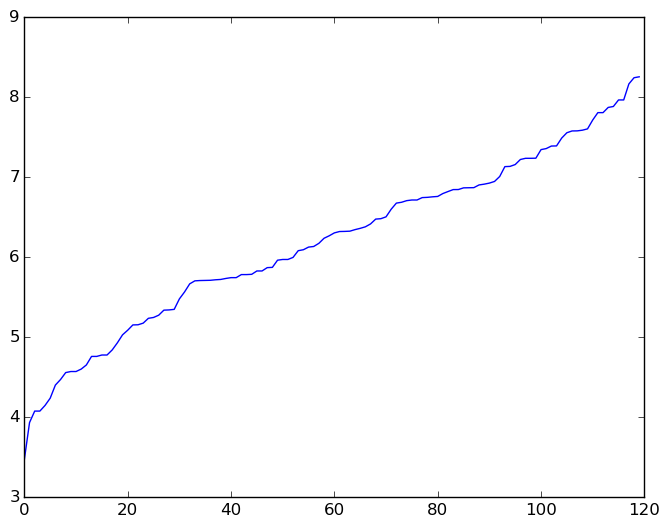

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f6c66a956d0>

In [12]:
plot(sort(score))

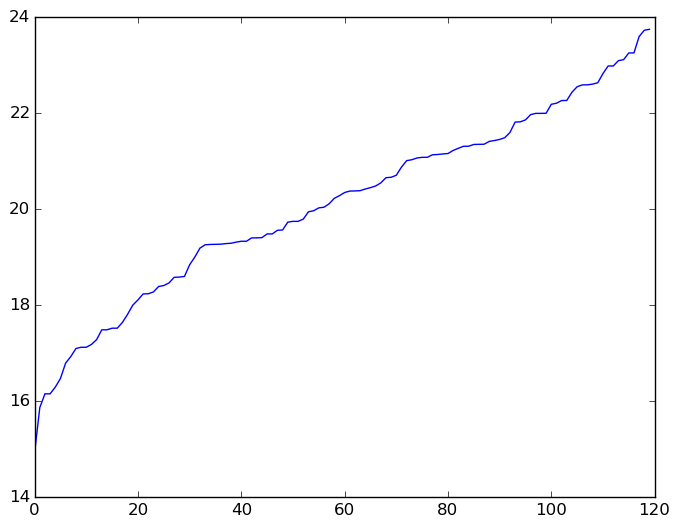

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fc35f7116d0>

In [7]:
plot(sort(score))

In [13]:
findmin(score)

(14.931621248548584,48)

In [4]:
findmin(score)

(3.475038825745721,48)

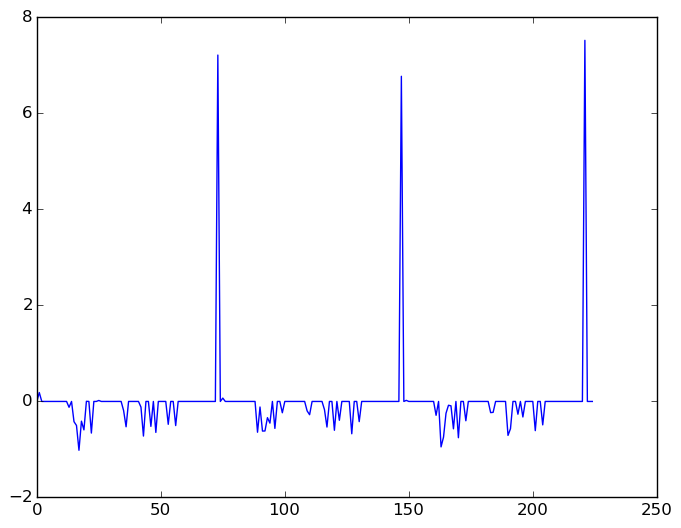

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f6c45f20350>

In [53]:
# plot(sort(A*xvec - b))

plot(round(A*xvec - b,10))

In [27]:
(xvec)[end-2:end]

3-element Array{FloatingPoint,1}:
 -0.159381
 -0.151433
 -0.143486

In [39]:
sum(Dp) - sum(Gp) - sum(Rp) - sum(deviations[1])

-40.65480278328571

In [29]:
line

(27,48)

In [37]:
angles[3][26] - angles[3][47]

-0.14348555034202343

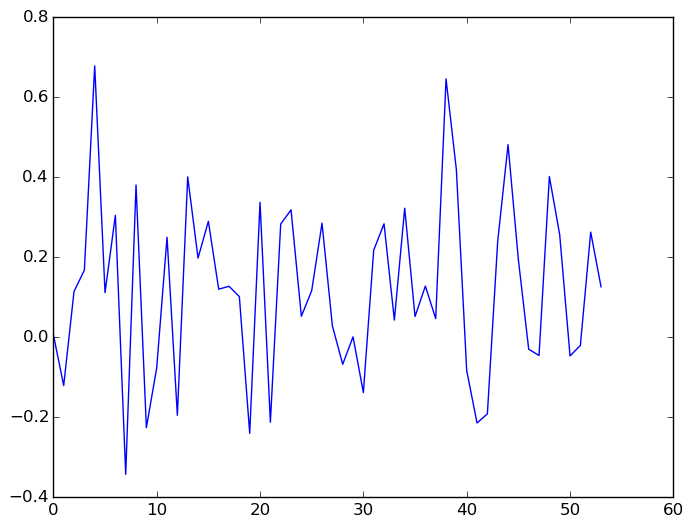

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f6c46167b50>

In [15]:
plot([deviations[1],deviations[2],deviations[3]])

In [23]:
3/(xvec'*Qtheta*xvec)[1]

43.52727793882629

In [19]:
Q_of_x[3]

-3.0

In [17]:
find(abs(float(round(A*xvec - b,10))).>0.0)

57-element Array{Int64,1}:
   2
  14
  16
  17
  18
  19
  20
  21
  23
  26
  36
  37
  43
   ⋮
 169
 171
 174
 184
 185
 191
 192
 195
 197
 202
 205
 222

In [19]:
line

(14,16)

In [25]:
A[end-2,nr + 14:nr+17]'

4x1 Array{Float64,2}:
 0.0
 1.0
 0.0
 0.0

In [26]:
find(A[end-2,:])

3-element Array{Int64,1}:
  31
  33
 274

In [36]:
A[end-2,274]

1.0

In [30]:
nr + 14 - 1

31

In [31]:
nr + 16 - 1

33

In [33]:
(n+nr)*3 + 1

274

In [30]:
(A*xvec)[find(A*xvec-b.>2)]

3-element Array{FloatingPoint,1}:
 -29.6384
 -26.7127
 -29.151 

In [33]:
(b)[find(A*xvec-b.>2)]

3-element Array{FloatingPoint,1}:
 -38.457 
 -36.7477
 -35.0384

In [37]:
x_star[find(A*xvec-b.>2)]

3-element Array{FloatingPoint,1}:
 -0.0694731
  0.174582 
  0.264364 

In [31]:
A[find(A*xvec-b.>2),:]

3x276 Array{Float64,2}:
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  1.0  0.0  0.0  0.0

In [38]:
xvec'*Qtheta*xvec

1-element Array{FloatingPoint,1}:
 0.00145869

In [38]:
[float(round(A*Qtheta*x_star,10)) b]

225x2 Array{FloatingPoint,2}:
  0.0          1.01329 
  0.0          1.16974 
  0.0         -1.17166 
  0.0         -0.48354 
  0.0         -0.464943
  0.0         -0.89269 
  0.0          0.781701
  0.0         -0.315863
  0.0         -1.13446 
  0.0         -1.26464 
  0.0          0.0     
  0.0          0.0     
  0.0          1.12341 
  ⋮                    
  0.0          0.0     
  0.0          0.0     
  0.0          0.0     
  0.0          0.0     
  0.0          0.0     
  0.0          0.0     
  0.0          0.0     
  0.0          0.0     
  0.0         -4.2711  
 -0.0074427    0.0     
 -0.0159076    0.0     
 -0.00441815   0.0     

In [5]:
b[(n+1)*3]

-35.03837771131582

In [ ]:
mismatch = 

In [ ]:
for t = 1:T
    start = (t-1)*n + 1
    stop = start + n - 1
    mismatch = -sum(netGen[start:stop])
    append!(btest,netGen[start:stop])
    push!(btest,mismatch)
end

In [11]:
sum(Dp) - sum(Rp) -sum(Gp) - sum(deviations[1])

-32.18825317566215

In [13]:
0.95*sum(Dp) - sum(Rp) - 0.95*sum(Gp) - sum(deviations[2])

-34.05679524740217

In [14]:
0.9*sum(Dp) - sum(Rp) - 0.9*sum(Gp) - sum(deviations[3])

-32.39333568072359

In [8]:
x_star'*R_of_x[1]*x_star

1-element Array{FloatingPoint,1}:
 0.000327967

Slider{Float64}([Input{Float64}] 7.5,"c",7.5,5.0:0.1:10.0)

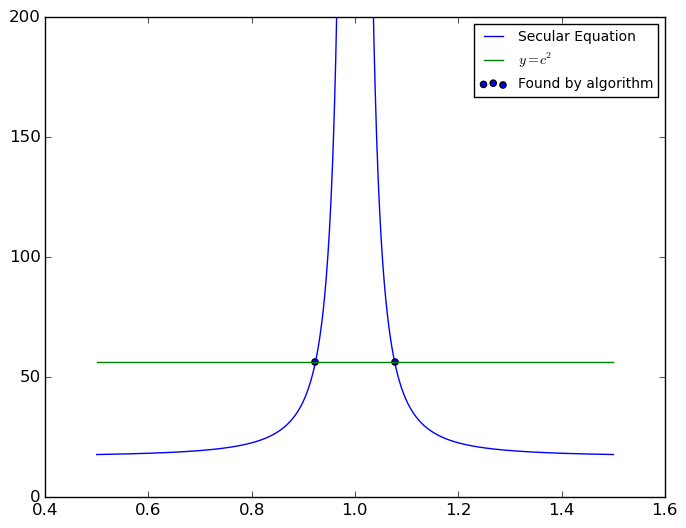

In [6]:
mu_vals = linspace(0.5*minimum(poles),1.5*maximum(poles),1000)

fig = figure()
@manipulate for c = 5:0.1:10; withfig(fig) do
        solutions,vectors = tr_solve_secular(D,d,Qtheta,c)
        # mu = solutions[1]
        # display(length(solutions))
        # w = find_w(mu,D,d,Qtheta)
        # (w'*w)[1]

        s_vals = [sumabs2(find_w(mu,D,d,Qtheta)) for mu in mu_vals]
        plot(mu_vals,s_vals)
        hold = true
        plot([mu_vals[1],mu_vals[end]],[c^2,c^2])
        ylim([0,200]) #ylim([0,2*c^2])
        xlim = [mu_vals[1],mu_vals[end]]
        scatter(solutions,c^2*ones(length(solutions)))
        legend(["Secular Equation",L"y = c^2","Found by algorithm"],fontsize=10)
    end
end

In [23]:
[Reigvec*Rkernel*Qobj*x_star d./2]

276x2 Array{FloatingPoint,2}:
 -1.66994e-16  -1.84714e-16
 -1.37027e-16  -1.14723e-16
  9.42162e-17   3.73619e-17
 -1.35371e-16  -1.47949e-16
 -1.54887e-16  -1.52762e-16
 -4.87143e-17  -8.73745e-17
 -9.28709e-17  -5.375e-17  
  7.02638e-17   9.16316e-17
  1.13997e-16   1.31298e-16
 -1.74778e-16  -1.37299e-16
 -1.88262e-16  -1.48549e-16
 -4.06896e-16  -3.69955e-16
  2.16001e-16   1.93536e-16
  ⋮                        
 -0.154915     -0.154915   
  0.631366      0.631366   
  0.104064      0.104064   
 -0.203106     -0.203106   
  0.0509949     0.0509949  
  0.221324      0.221324   
 -0.0246545    -0.0246545  
  0.123948      0.123948   
  0.216208      0.216208   
  0.47541       0.47541    
  0.626996      0.626996   
  0.491082      0.491082   

# Can we ignore linear terms in the constraint?

I don't think so. It looks like there is a leftover linear term after translating both quadratics. If this is the case, then after the two rotations we have something like

\begin{align}
& \min & w^\top Q_{obj} w + w^\top d & \\
& s.t. & w^\top Q_{\theta} w + w^\top d_2 &= \bar{c}
\end{align}

Now the Lagrange condition is

\begin{align}
2 w^\top Q_{obj} + d &= \mu(